# 1. Data Preparation

## 1.1 Load Data

In [1]:
import pandas as pd
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
path = '/Users/pliu/Downloads/mnist/'
train, test = pd.read_csv(path+'train.csv'), pd.read_csv(path+'test.csv') 
train.shape #(42000, 785)
test.shape #(28000, 784)

(28000, 784)

In [3]:
Y_train, X_train = train['label'], train.drop(['label'], axis=1)

In [4]:
# free some space
del train

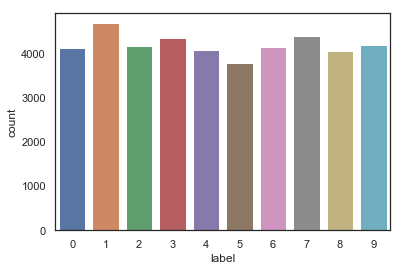

In [5]:
# check distribution of target var
sns.countplot(Y_train)
# findings: balanced distribution

## 1.2 Missing Value

In [6]:
# Missing value statistics
def missing_data(df=X_train):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
missing_data().head(20) # no missing values
missing_data(test).head(20) # no missing values

,Total,Percent
pixel783,0,0.0
pixel268,0,0.0
pixel266,0,0.0
pixel265,0,0.0
pixel264,0,0.0
pixel263,0,0.0
pixel262,0,0.0
pixel261,0,0.0
pixel260,0,0.0
pixel259,0,0.0


## 1.3 Normalization

In [19]:
# perform a grayscale normalization
# reason: 1. reduce the effect of scaling 2. accelerate converge
# normalize the data
X_train = X_train / 255.0
test = test / 255.0

## 1.4 Reshape

In [7]:
# reshape image in 3 Dimensions (height = 28px, width = 28px, canal = 1)
X_train = X_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

In [8]:
# X_train before reshaping is a Pandas.DataFrame which has 42k rows and 784 (28*28) features
X_train.shape # 42000 observations in 3D format: width 28, height 28, canal 1

(42000, 28, 28, 1)

## 1.5 Label Encoding

In [9]:
# label vector from 1-D to hot-encoding
Y_train = to_categorical(Y_train, num_classes=10) #numpy.ndarray

In [10]:
Y_train[1]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

## 1.6 Split dataset

In [11]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=2)

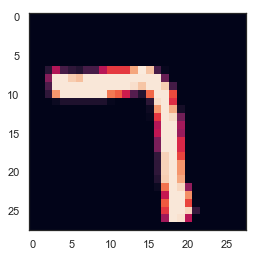

In [17]:
# have a look at the data
g = plt.imshow(X_train[1111][:,:,0])

# 2. CNN

## 2.1 Define the model

In [ ]:
# use Keras Sequential API - add one layer at a time, starting from the input
# 1st layer: Conv2D - convolutional layer
# set 32 filters for the two firsts conv2D layers
# set 64 filters for the two lasts ones
# each filter transforms a part of the image using the kernel filter
# filter can be seen as a transformation of the image

# 2nd layer: pooling layer (MaxPool2D)
# acts as a down-sampling filter
# used to reduce computational cost and overfitting
# have to choose the pooling size (the area size pooled each time)
# the higher the pooling dimension, the more important the downsampling is

# dropout: the regularization method - setting a proportion of nodes' weights to zero
# improves generalization and reduces overfitting

# relu: the activation func max(0, x) 
# add non-linearity to the network

# Flatten layer - map the final features into a one single 1D vector
# so as to mke use of fully connected layers after some convolutional / maxpool layers
# it combines all the found local features of the previous convolutional layers

# Dense in the last layer
# implement two fully-connected (Dense) layers which is just ANN classifier
# (Dense(10, activation='softmax')) outputs the probability of each class

# CNN architechture: 
#    Input -> [[Conv2D -> relu] * 2 -> MaxPool2D -> Dropout] * 2 -> Flatten -> Dense -> Dropout -> Output

In [46]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import itertools

In [19]:
# use Keras Sequential API, just to add one layer at a time
model = Sequential()

# add the first layer - Conv2D for two times
# Conv2D is like a set of learnable filters

# what is kernel in Conv2D ??
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu'))

# add the 2nd layer in CNN: the pooling layer
# MaxPool2D - a downsampling filter
# reduce computational cost and overfitting

model.add(MaxPool2D(pool_size=(2,2)))

# add regularization, improve generalization and reduces overfitting
model.add(Dropout(0.25))

# add Flatten
model.add(Flatten())

# add Dense() fully-connected layers
model.add(Dense(256, activation = 'relu'))

model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

## 2.2 Setup optimizer and annealer

In [20]:
# evaluation - categorical_crossentropy

# optimizer - RMSprop
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# metric function - accuracy - only for evaluation not for training

# compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
# dynamic Learning Rate
# set up a learning rate annelar - ReduceLROnPlateau from keras.callbacks
# rule: reduce LR by half if the accuracy is not improved after 3 epochs
learning_rate_reduction = ReduceLROnPlateau(monitor='val_auc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

# some other parameters
epochs, batch_size = 8, 86

## 2.3 Data augmentation

In [30]:
# expand dataset artifically in order to avoid overfitting problem
# make existing dataset even larger
# how? alter the training data with small transformation to reproduce the variations
# occuring when someone is writting a digit

# data augmentation: grayscales, horizontal flips, vertical flips,
# random crops, color jitters, translations, rotations etc.

# use data augumentation to prevent from overfitting
datagen = ImageDataGenerator(featurewise_center=False, # set input mean to zero over the dataset
                             samplewise_center=False, # set each sample mean to 0
                             featurewise_std_normalization=False, # divide inputs by dataset std
                             samplewise_std_normalization=False, # divide each input by its std
                             zca_whitening=False, # apply ZCA whitening
                             rotation_range=10, # randomly rotate images in the range(degrees 0 to 180)
                             zoom_range=0.1, # randomly zoom image
                             width_shift_range=0.1, # randomly shift img horizontally (fraction of total width)
                             height_shift_range=0.1, # randomly shift img vertically (fraction of total height)
                             horizontal_flip=False, # randomly flip img
                             vertical_flip=False) # # randomly flip img

datagen.fit(X_train)

In [31]:
# fit the model
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                              epochs=epochs, validation_data=(X_val, Y_val),
                              verbose=2, steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=[learning_rate_reduction])

Epoch 1/8
 - 214s - loss: 6.7577 - acc: 0.5786 - val_loss: 5.3960 - val_acc: 0.6645
Epoch 2/8
 - 208s - loss: 6.5056 - acc: 0.5952 - val_loss: 5.0445 - val_acc: 0.6869
Epoch 3/8
 - 220s - loss: 6.6116 - acc: 0.5886 - val_loss: 5.1015 - val_acc: 0.6831
Epoch 4/8
 - 229s - loss: 6.5400 - acc: 0.5932 - val_loss: 4.7327 - val_acc: 0.7055
Epoch 5/8
 - 213s - loss: 6.3427 - acc: 0.6054 - val_loss: 5.0170 - val_acc: 0.6881
Epoch 6/8
 - 170s - loss: 5.9634 - acc: 0.6291 - val_loss: 3.7995 - val_acc: 0.7640
Epoch 7/8
 - 170s - loss: 5.7704 - acc: 0.6411 - val_loss: 3.7153 - val_acc: 0.7693
Epoch 8/8
 - 171s - loss: 5.7584 - acc: 0.6421 - val_loss: 4.0180 - val_acc: 0.7507


In [33]:
# submission
results = model.predict(test)

NameError: name 'np' is not defined

In [34]:
# select the index of with the max probability
import numpy as np
results = np.argmax(results, axis=1)

results = pd.Series(results, name='Label')

ids = pd.Series(range(1,28001), name='ImageId')

submission = pd.concat([ids, results], axis=1)

submission.to_csv('cnn_mnist.csv', index=False)

# 3. Evaluate the Model

## 3.1 Training and validation curves

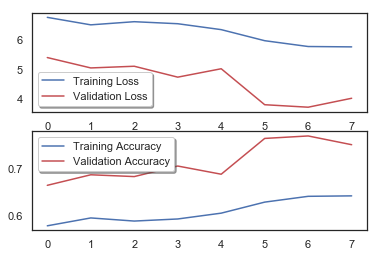

In [38]:
# plot the loss and accuracy curve for training and validation
fig, ax = plt.subplots(2, 1)
# history.history is a dict with key[val_loss, val_acc, loss, acc] and values [value for value in epoch]
ax[0].plot(history.history['loss'], color='b', label='Training Loss')
ax[0].plot(history.history['val_loss'], color='r', label='Validation Loss', axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label='Training Accuracy')
ax[1].plot(history.history['val_acc'], color='r', label='Validation Accuracy')
legend = ax[1].legend(loc='best', shadow=True)

## 3.2 Confusion Matrix

In [42]:
# print the values from the validation dataset
Y_pred = model.predict(X_val)

# Convert predictions classes to one hot encoders
Y_pred_classes = np.argmax(Y_pred, axis=1)

# convert validation observation to one hot encoders
Y_true = np.argmax(Y_val, axis=1)

# compute confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

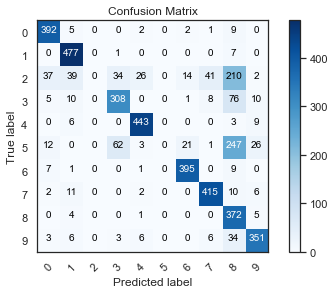

In [48]:
def plot_confusion_mtx(confusion_mtx, classes,
                       normalize=False, title='Confusion Matrix',
                       cmap=plt.cm.Blues):
    """Prints and plots the confusion matrix
    Args:
      confusion_mtx: confusion matrix instance
      classes: labels of the training dataset
      normalize: flag to control the values in the plot, True: ratio, False: real num
      title: plot title
      cmap: colors of plot
    Return:
      
    """
    plt.imshow(confusion_mtx, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        confusion_mtx = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:,np.newaxis]
    
    boundry_b, boundry_u = range(confusion_mtx.shape[0]), range(confusion_mtx.shape[1])
    threshold = confusion_mtx.max() / 2.
    
    for i, j in itertools.product(boundry_b, boundry_u):
        plt.text(j, i, confusion_mtx[i,j],
                horizontalalignment='center',
                color = 'white' if confusion_mtx[i,j] > threshold else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
        
plot_confusion_mtx(confusion_mtx, classes=range(10))        